Some weights of the model checkpoint at facebook/detr-resnet-101 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


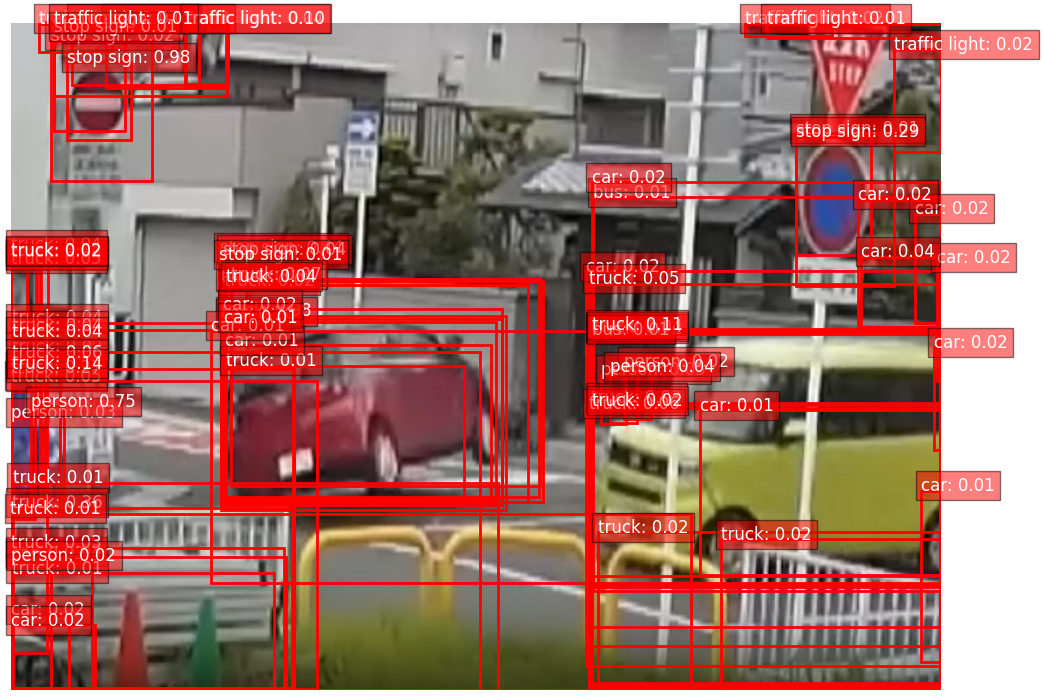

In [11]:
import torch
import torchvision.transforms as T
from PIL import Image
import requests
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from transformers import DetrImageProcessor, DetrForObjectDetection,CLIPProcessor, CLIPModel

import warnings
warnings.filterwarnings('ignore')


# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Load the pretrained DETR model and processor
detr_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-101")
detr_model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-101").to(device)
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Load an image from URL or local path
#image_url = "tree root lifting the pavement.png"
image_url = "overturned red car indicating a collision.png"
#image_url = "http://images.cocodataset.org/val2017/000000039769.jpg"
#image = Image.open(requests.get(image_url, stream=True).raw)
org_image = Image.open(image_url).convert("RGB")
scale = 1.8
image = org_image.resize((int(org_image.width * scale), int(org_image.height * scale)))

# Preprocess the image
inputs = detr_processor(images=image, return_tensors="pt").to(device)

# Forward pass
with torch.no_grad():
    outputs = detr_model(**inputs)

scores = outputs.logits.softmax(-1)[..., :-1].max(-1).values
threshold = scores.quantile(0.2)  # Keep top 80% confident predictions

# Post-process the results (keep only high-confidence predictions)
target_sizes = torch.tensor([image.size[::-1]])  # (height, width)
results = detr_processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=threshold)[0]

# Draw results
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(image)
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    xmin, ymin, xmax, ymax = box.cpu().numpy()
    ax.add_patch(patches.Rectangle(
        (xmin, ymin), xmax - xmin, ymax - ymin,
        fill=False, edgecolor='red', linewidth=2
    ))
    caption = f"{detr_model.config.id2label[label.item()]}: {score:.2f}"
    ax.text(xmin, ymin, caption, fontsize=12, color='white',
            bbox=dict(facecolor='red', alpha=0.5))

plt.axis("off")
plt.show()


Detected: overturned red car indicating a collision with probability 0.31
Detected: overturned red car indicating a collision with probability 0.31
Detected: overturned red car indicating a collision with probability 0.31


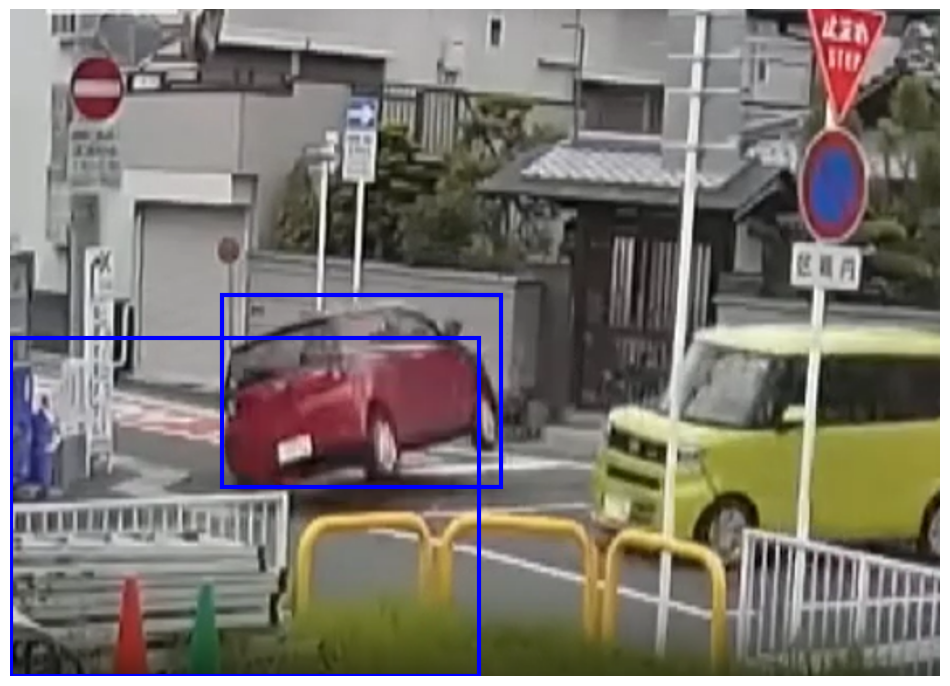

In [18]:
import torchvision.ops as ops

# Crop image regions from bounding boxes
image_crops = []
boxes = []
for box in results["boxes"]:
    xmin, ymin, xmax, ymax = box.tolist()  # convert tensor to float list
    crop = image.crop((xmin, ymin, xmax, ymax))
    image_crops.append(crop)
    boxes.append((xmin, ymin, xmax, ymax))

# CLIP: Encode region crops and text prompts
#text_labels = ["tree root lifting the pavement"]
text_labels = ["overturned red car indicating a collision"]
text_inputs = clip_processor(text=text_labels, return_tensors="pt", padding=True)
text_features = clip_model.get_text_features(**text_inputs)
text_features = text_features / text_features.norm(dim=-1, keepdim=True)

# Run CLIP on each region and score similarity
matching_results = []
for crop, box in zip(image_crops, boxes):
    image_inputs = clip_processor(images=crop, return_tensors="pt")
    image_features = clip_model.get_image_features(**image_inputs)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

    # Compute cosine similarity
    similarity = (image_features @ text_features.T).squeeze()
    top_prob, top_idx = similarity.max(dim=0)

    if top_prob > 0.31:  # Adjust threshold as needed
        print(f"Detected: {text_labels[top_idx]} with probability {top_prob.item():.2f}")
        label = text_labels[top_idx]
        matching_results.append((box, label, top_prob.item()))


# Convert to tensors for NMS
if matching_results:
    box_tensor = torch.tensor([b for b, _, _ in matching_results], dtype=torch.float32)
    score_tensor = torch.tensor([s for _, _, s in matching_results], dtype=torch.float32)

    # Apply NMS: threshold = IoU, e.g. 0.3
    keep_indices = ops.nms(box_tensor, score_tensor, iou_threshold=0.3)

    # Filter results
    matching_results = [matching_results[i] for i in keep_indices]

# Visualize results
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(image)

for (xmin, ymin, xmax, ymax), label, score in matching_results:
    ax.add_patch(patches.Rectangle(
        (xmin, ymin), xmax - xmin, ymax - ymin,
        fill=False, edgecolor='blue', linewidth=3
    ))
    #ax.text(xmin, ymin, f"{label}: {score:.2f}", color='white', bbox=dict(facecolor='green', alpha=0.6))

plt.axis("off")
plt.show()